# Movie Recommendation Systems

## Purpose

There are so many movies and online information about them to help viewers decide what to watch. With an overwhelming amount of information, it can be challenging for people to decide and watch a movie that they would enjoy. Recommendation systems are developed to help resolve this issue by providing movie recommendations. 

The following notebooks encode various recommendation systems using information provided by the latest and smallest dataset from [MovieLens](https://grouplens.org/datasets/movielens/). The selected content-based and collaborative filtering recommendation systems were chosen with respect to evaluating them appropriately across the same metric, the **mean average precision at k (MAP@k)**. 

## Contents

**1. Setup** - importing libraries and functions

**2. Load Data** - loading datasets

**3. Clean Data** - removing duplicates 

**4. Exploratory Data Analysis (EDA)** - data visualisations

**5. Data Preparation** - preparing data for modelling purposes

**6. Modelling** - built models on the training set

**7. Evaluation** - evaluate models with MAP@k using the test set 

## 1. Setup

In [6]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

import surprise
from surprise import Dataset, Reader, SVD, KNNWithMeans, KNNBasic
from sklearn.model_selection import train_test_split

import ml_metrics as metrics

%matplotlib inline

In [7]:
#Load data
def load_file(df): 
    """
    Reads csv file as a Pandas dataframe.
    
    Parameters
    ----------
    df: name of csv file 
    
    Returns 
    -------
    Dataframe of csv file
    
    ---
    """
    return pd.read_csv(df)

In [8]:
def surprise_algo(algo, trainset_surprise, testset_surprise, userIds): 
    '''
    A list with lists of recommendations for each user; list requires to be stored elsewhere
    
    ---
    Parameters
    
    
    algo: Surprise package algorithm  
    
    trainset_surprise: training data, setup from Surprise (not the same as Pandas dataframe setup) 
    
    testset_surprise: testing data, setup from Surprise (not the same as Pandas dataframe setup) 
    
    userIds: list of all the userIds; to recommend each user in userIds 
    
    ---
    Returns 
    
    A list with lists of recommendations 
    
    ---
    
    '''

    #Fit SVD recommender
    algo.fit(trainset_surprise)
    algo_pred = algo.test(testset_surprise)
    
    #Dataframe of test set including predicted ratings
    algo_pred = pd.DataFrame(algo_pred).drop('details', axis=1)
    algo_pred.columns = ['userId','movieId','rating','pred_rating']
    algo_pred = algo_pred.sort_values(['userId','pred_rating'], ascending=[True,False])
    
    #Recommendations for all users in the test data
    algo_recs = []

    for userId in userIds:
        algo_recs_ = algo_pred.set_index('userId').loc[userId]['movieId'].tolist()
        algo_recs.append(algo_recs_)
    
    return algo_recs

## 2. Load data

In [9]:
#Load data and define dataframes
movies = load_file("movies.csv")
ratings = load_file("ratings.csv")

## 3. Clean data

### 3.1 'movies' dataframe

**3.1.1 Preview**

In [10]:
#movies dataframe preview
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**3.1.2 Check nulls and duplicate rows**

In [11]:
print('Number of nulls in "movies" dataframe: \n' , movies.isnull().sum())
print('\n Number of duplicate rows in "movies" dataframe :', movies.duplicated().sum())

Number of nulls in "movies" dataframe: 
 movieId    0
title      0
genres     0
dtype: int64

 Number of duplicate rows in "movies" dataframe : 0


**3.1.3 Check duplicate movie titles**

Only 'title' in 'movies' is prone to duplicates.

In [12]:
#Number of movie title duplicates
print('Number of duplicates: ', movies[['title']].duplicated().sum())

Number of duplicates:  5


**3.1.4: Clean duplicate movie titles (genres)**

*3.1.4.1 Investigate*

In [13]:
#Dataframe of duplicates
duplicates = movies[movies['title'].duplicated()]
display(duplicates)

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [14]:
#Store movieIds and titles of duplicates
duplicate_id = list(duplicates['movieId'])
duplicate_title = list(duplicates['title'])

In [15]:
#Dataframe of movie titles with duplicates
duplicate_df = movies[movies['title'].isin(duplicate_title)]
duplicate_df

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [16]:
#Dataframe of original movies with duplicates
original_df = duplicate_df[~duplicate_df['movieId'].isin(duplicate_id)]
display(original_df)

#Original movieIds
original_id = list(original_df['movieId'])

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller


*3.1.4.2: Combine 'genres' by movie title*

* Duplicates show different 'movieId' and 'genres' under the same 'title
* For each movie title, one of the 'genres' are a subset of another 

Actions:
1. Combine genres: unique genre values extracted later using split, list and set
2. Merge combined genres to 'movies': 
    * Fillna with non-duplicates in new genre col 
    * Drop original 'genres' from "movies" 

In [17]:
#1. Combine genres
merge_genres = duplicate_df.groupby(['title'])['genres'].apply('|'.join).reset_index()
merge_genres

,title,genres
0,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller|Comedy|Crime|Drama...
1,Emma (1996),Comedy|Drama|Romance|Romance
2,Eros (2004),Drama|Drama|Romance
3,Saturn 3 (1980),Adventure|Sci-Fi|Thriller|Sci-Fi|Thriller
4,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller|Action|Sci-Fi


In [18]:
#'movies' length
len(movies)

9742

In [19]:
#Remove duplicate titles in movies
movies = movies[~movies['title'].duplicated()]

In [20]:
#Check if duplicates were removed from 'movies'
len(movies)

9737

In [21]:
#2. Merge combined genres to 'movies' 
movies = pd.merge(movies, merge_genres, on='title', how='left')

In [22]:
#Check merging of combined genres  
movies['genres_y'].notnull().sum()

5

In [23]:
#Fill NaNs with original genres - originals were not duplicates
movies['genres_y'] = movies['genres_y'].fillna(movies['genres_x'])

In [24]:
#Check number of filling non-duplicates
sum(movies['genres_y'] == movies['genres_x'])

9732

In [25]:
#Drop original genres column, 'genres_x'
movies.drop('genres_x',axis=1, inplace=True)

In [26]:
#Rename new genres, which includes combined genres of duplicates
movies.rename(columns={'genres_y':'genres'}, inplace=True)

In [27]:
#Convert strings of genres into lists
movies['genres'] = movies['genres'].apply(lambda x: str(x).split('|'))

In [28]:
#Keep list of uniques from each list of genres
movies['genres'] = movies['genres'].apply(lambda x: list(set(x)))

In [29]:
#Explode 'genres'
#Create a row for each list element from a column containing lists
movies = movies.explode('genres')
len(movies)

22074

In [30]:
#Preview
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Fantasy
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Animation


**3.1.5: Extract years from 'title' into new col 'year'**

In [31]:
#Separate year from 'title' column and placed into a new column 'year'

#Create 'year' column from extracting title 
movies['year'] = movies['title'].str.extract('(\(\d\d\d\d\))',expand=False)
#Remove parentheses in 'year' column
movies['year'] = movies['year'].str.extract('(\d\d\d\d)',expand=False)
#Removing '(year)' in 'title' column
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '')
#Apply the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())

<ipython-input-31-da48865549e6>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '')


In [32]:
#Preview
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,Fantasy,1995
0,1,Toy Story,Comedy,1995
0,1,Toy Story,Adventure,1995
0,1,Toy Story,Children,1995
0,1,Toy Story,Animation,1995
1,2,Jumanji,Fantasy,1995
1,2,Jumanji,Children,1995
1,2,Jumanji,Adventure,1995
2,3,Grumpier Old Men,Comedy,1995
2,3,Grumpier Old Men,Romance,1995


In [33]:
#Convert years from string to integers
movies['year'] = pd.to_numeric(movies['year'])
movies['year'] = movies['year'].astype('Int64')

In [34]:
#Number of missing 'year' values 
movies['year'].isnull().sum()

16

In [35]:
#View missing 'year' movie titles
movies[movies['year'].isnull()]

,movieId,title,genres,year
6058,40697,Babylon 5,Sci-Fi,<NA>
9029,140956,Ready Player One,Thriller,<NA>
9029,140956,Ready Player One,Action,<NA>
9029,140956,Ready Player One,Sci-Fi,<NA>
9089,143410,Hyena Road,(no genres listed),<NA>
9134,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),<NA>
9175,149334,Nocturnal Animals,Thriller,<NA>
9175,149334,Nocturnal Animals,Drama,<NA>
9255,156605,Paterson,(no genres listed),<NA>
9363,162414,Moonlight,Drama,<NA>


**Findings**
* These titles are likely involving a range of years
* These nulls are left untouched - not many relative to the size of the dataframe. 

In [36]:
#Preview
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,Fantasy,1995
0,1,Toy Story,Comedy,1995
0,1,Toy Story,Adventure,1995
0,1,Toy Story,Children,1995
0,1,Toy Story,Animation,1995
1,2,Jumanji,Fantasy,1995
1,2,Jumanji,Children,1995
1,2,Jumanji,Adventure,1995
2,3,Grumpier Old Men,Comedy,1995
2,3,Grumpier Old Men,Romance,1995


### 3.2 'ratings' dataframe

**3.2.1 Preview**

In [37]:
#ratings dataframe preview
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**3.2.2 Check nulls and duplicate rows**

In [38]:
print('Number of nulls in "ratings" dataframe: \n', ratings.isnull().sum())
print('\n Number of duplicates rows in "ratings" dataframe :', ratings.duplicated().sum())

Number of nulls in "ratings" dataframe: 
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

 Number of duplicates rows in "ratings" dataframe : 0


**3.2.3 Drop 'timestamp'**
* 'timestamp' is not relevant for our purposes

In [39]:
ratings.drop('timestamp', axis=1, inplace=True)

**3.2.4 Update duplicate movieIds to original movieIds**

*3.2.4.1 Find duplicates in 'ratings'*

In [40]:
#Find movieIds that require updating 
#movieIds reference duplicates
duplicate_ratings = ratings[ratings['movieId'].isin(duplicate_id)]
duplicate_ratings

,userId,movieId,rating
4747,28,64997,3.5
11451,68,64997,2.5
17819,111,144606,4.0
49832,318,147002,4.0
80596,509,26958,3.5
81458,514,168358,2.5


*3.2.4.2 Match duplicates with their original 'movieId'*

In [41]:
#Update movieIds - replace duplicate movieIds with original movieIds
print('List of original movieIds: ', original_id)
print('List of duplicate movieIds: ', duplicate_id)

#Dataframe of correpsonding original and duplicate movieIds
update_id = pd.DataFrame([original_id, duplicate_id]).transpose()
update_id.columns = ['original_id','duplicate_id']
display(update_id)

List of original movieIds:  [838, 2851, 6003, 32600, 34048]
List of duplicate movieIds:  [26958, 64997, 144606, 147002, 168358]


,original_id,duplicate_id
0,838,26958
1,2851,64997
2,6003,144606
3,32600,147002
4,34048,168358


*3.2.4.3 Merge to update 'movieId' accordingly*

In [42]:
#Merge 
ratings = pd.merge(ratings, update_id, left_on='movieId', right_on='duplicate_id', how='left')

#Preview
ratings.head()

,userId,movieId,rating,original_id,duplicate_id
0,1,1,4.0,NaN,NaN
1,1,3,4.0,NaN,NaN
2,1,6,4.0,NaN,NaN
3,1,47,5.0,NaN,NaN
4,1,50,5.0,NaN,NaN


In [43]:
#Number of updated movieIds
ratings['original_id'].notnull().sum()

6

*3.2.4.4 Update movieIds by replacing duplicates*

In [44]:
#Fill nulls with original movieIds (no updates needed for these)
ratings['original_id'] = ratings['original_id'].fillna(ratings['movieId'])

#Drop irrelevant columns
ratings.drop(['movieId','duplicate_id'], axis=1, inplace=True)

#Rename back to original 'movieId'
ratings.rename(columns={'original_id':'movieId'}, inplace=True)

#Preview
ratings.head()

,userId,rating,movieId
0,1,4.0,1.0
1,1,4.0,3.0
2,1,4.0,6.0
3,1,5.0,47.0
4,1,5.0,50.0


In [45]:
#Convert movieIds to integers
ratings['movieId'] = ratings['movieId'].astype(int)

In [46]:
#Rearrange columns back to original order
ratings = ratings[['userId','movieId','rating']]

*3.2.4.4 Update movieIds by replacing duplicates*

In [47]:
#Check for duplicates after updates
pd.merge(ratings, ratings[ratings.duplicated()], how='inner')

,userId,movieId,rating
0,111,6003,4.0
1,111,6003,4.0
2,509,838,3.5
3,509,838,3.5


In [48]:
#Check length
len(ratings)

100836

In [49]:
#Drop duplicates
ratings.drop_duplicates(inplace=True)

In [50]:
#Check length
len(ratings)

100834

**3.2.4 Counts**

In [51]:
#Number of users
len(set(ratings['userId']))

610

In [52]:
#Range - number of ratings
ratings.groupby('userId')['rating'].count().sort_values()

userId
442      20
406      20
147      20
194      20
569      20
       ... 
274    1346
448    1864
474    2108
599    2478
414    2698
Name: rating, Length: 610, dtype: int64

**Findings**
* More movies (items) than users; implying that item-item collaborative filtering would provide better results than user-user collaborative filtering
* Each user rated at least 20 movies (at most 2,698 movies).

In [53]:
#Preview
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [54]:
print('Number of movies in "ratings": ', len(set(ratings['movieId'])))
print('Number of movies in "movies": ', len(set(movies['movieId'])))

Number of movies in "ratings":  9719
Number of movies in "movies":  9737


In [55]:
#Check what movies are missing between the two 
movies_movielist = pd.Series(list(set(movies['movieId'])))
ratings_movielist = pd.Series(list(set(ratings['movieId'])))

In [56]:
#Movies in 'movies' and not in 'ratings'
movies_movielist[movies_movielist.isin(ratings_movielist)==False]

925      1076
1458    34482
2489     2939
2818     3338
2914     3456
3530     4194
4665     5721
5259     6668
5372     6849
5497     7020
5900     7792
6297     8765
7818    85565
8504    25855
8563    26085
9437    30892
9626    32160
9669    32371
dtype: int64

In [57]:
#Movies in 'ratings' and not in 'movies'
ratings_movielist[ratings_movielist.isin(movies_movielist)==False]

Series([], dtype: int64)

In [58]:
#Store list of missing movieIds
missing_movies = list(movies_movielist[movies_movielist.isin(ratings_movielist)==False])

**Findings**
* Will note that not all movies have been seen by any of the users.

### 4. Exploratory Data Analysis (EDA)

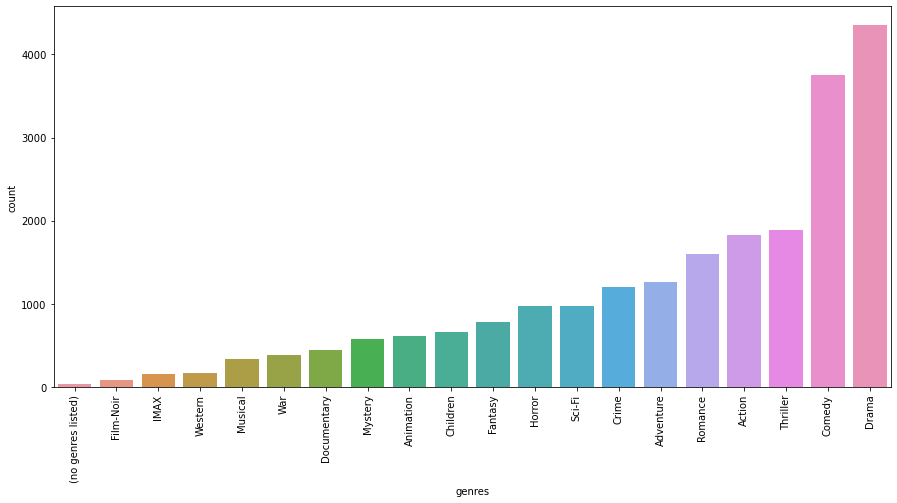

In [59]:
#1. Number of releases for each genre
plt.figure(figsize=(15,7))
sns.countplot(data = movies, x = 'genres', order = movies['genres'].value_counts(ascending=True).index)
plt.xticks(rotation=90)
plt.savefig('plot1.png')
plt.show()

**Findings**
* Drama and Comedy are the most common genres found, followed by Thriller, Romance and Action. 

In [60]:
#2. Dataframe for lineplot - number of releases per year
year_df = pd.DataFrame(movies.groupby(['year'])['title'].count().reset_index())
year_df

,year,title
0,1902,4
1,1903,2
2,1908,3
3,1915,2
4,1916,7
...,...,...
101,2014,631
102,2015,598
103,2016,436
104,2017,301


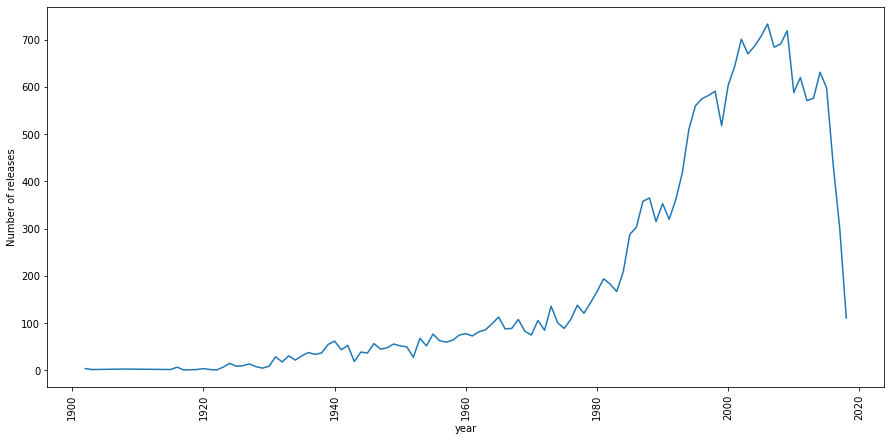

In [72]:
#2. Lineplot - number of releases each year
plt.figure(figsize=(15,7))
sns.lineplot(data=year_df, x='year', y='title')

years = range(1900,2021,20)
plt.xticks(rotation=90)
plt.xticks(years)
plt.ylabel('Number of releases')

plt.savefig('plot2.png')
plt.show()

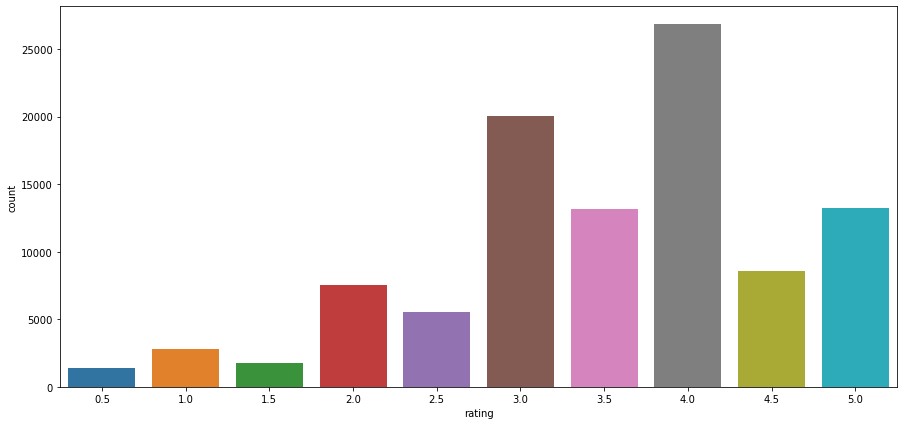

In [62]:
#3. Countplot of ratings
plt.figure(figsize=(15,7))
sns.countplot(data=ratings, x='rating')

plt.savefig('plot3.png')
plt.show()

In [63]:
#See descriptive statistics of ratings
pd.DataFrame(ratings['rating'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
rating,100834.0,3.501552,1.042538,0.5,3.0,3.5,4.0,5.0


**Findings**
* Lowest rating is 0.5
* Most ratings 3 or 4, showing a bimodal distribution 
* Ratings are also slightly skewed left
* Users are optimistic to vote above 2.5 out of 5
* Users perceive a 3 out of 5 as below average, 3.5 out of 5 as an average rating, and 4 out of 5 as an above-average rating. 

In [64]:
#4. Dataframe for lineplot - number of releases per year for each genre
year_genres_df = pd.DataFrame(movies.groupby(['year','genres'])['title'].count().reset_index())
year_genres_df

,year,genres,title
0,1902,Action,1
1,1902,Adventure,1
2,1902,Fantasy,1
3,1902,Sci-Fi,1
4,1903,Crime,1
...,...,...,...
1496,2018,Horror,4
1497,2018,Mystery,5
1498,2018,Romance,1
1499,2018,Sci-Fi,13


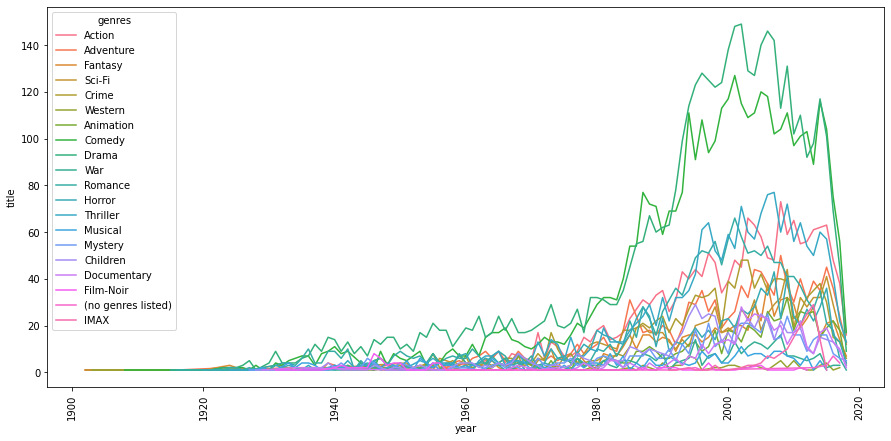

In [65]:
#4. Lineplot - number of releases per year for each genre
plt.figure(figsize=(15,7))
sns.lineplot(data=year_genres_df, x='year', y='title', hue='genres')

years = range(1900,2021,20)
plt.xticks(rotation=90)
plt.xticks(years)

plt.savefig('plot4.png')
plt.show()

In [66]:
#5. Box plot of genres in ratings data

#Merge individual genres
ratings_df = ratings.merge(movies, how='left', on='movieId')

#Drop columns irrelevant for EDA 
ratings_df.drop(['userId','movieId'], axis=1, inplace=True)

In [67]:
#Preview
ratings_df.head()

,rating,title,genres,year
0,4.0,Toy Story,Fantasy,1995
1,4.0,Toy Story,Comedy,1995
2,4.0,Toy Story,Adventure,1995
3,4.0,Toy Story,Children,1995
4,4.0,Toy Story,Animation,1995


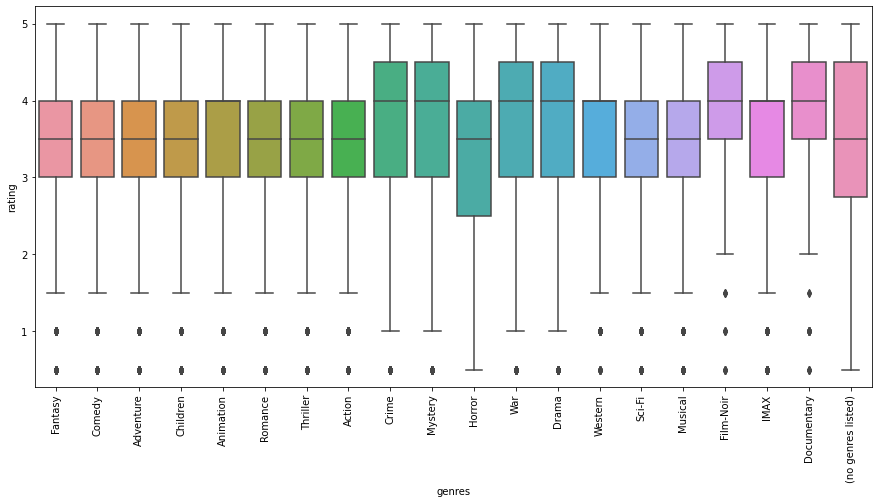

In [68]:
#Box plot of genres in ratings data
plt.figure(figsize=(15,7))
sns.boxplot(data = ratings_df, x = 'genres', y = 'rating')
plt.xticks(rotation=90)

#Save figure
plt.savefig('plot5.png')

#Show figure
plt.show()

**Findings**
* The boxplot of each genre's distribution of ratings show higher median ratings for Drama, Crime, War, Mystery, Animation, IMAX, Film-Noir and Documentary movies, while Horror and (no genres listed) show a more likely tendency of lower ratings. The average ratings, as shown by the bar plot of average ratings for each genre, reflect these findings also. 

In [69]:
#6. Average ratings
avg_ratings = ratings_df.groupby(['genres'])['rating'].mean().sort_values().reset_index()
avg_ratings

,genres,rating
0,Horror,3.258195
1,Comedy,3.384705
2,Children,3.412956
3,Action,3.447983
4,Sci-Fi,3.455721
5,(no genres listed),3.489362
6,Fantasy,3.491001
7,Thriller,3.493649
8,Romance,3.506561
9,Adventure,3.508525


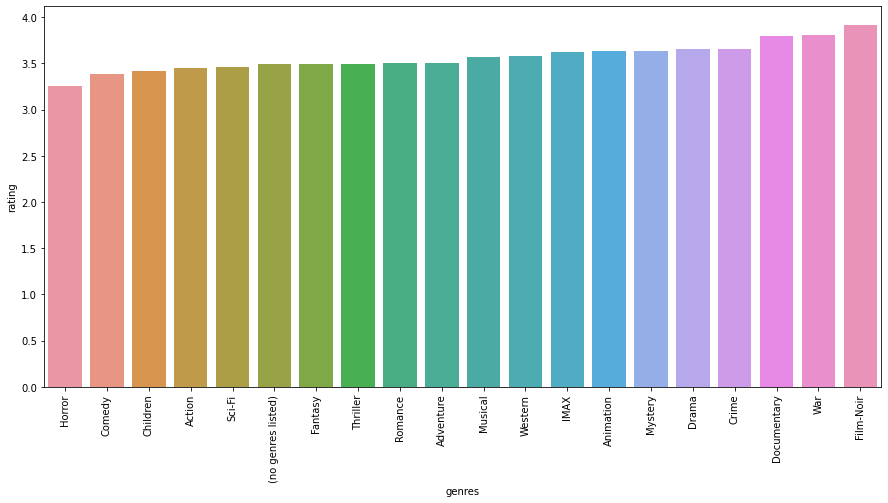

In [70]:
#6. Bar plot of average ratings for each genre
plt.figure(figsize=(15,7))
sns.barplot(data = avg_ratings, x='genres',y='rating')
plt.xticks(rotation=90)

#Save figure
plt.savefig('plot6.png')

#Show figure
plt.show()

**Findings**
* Film-Noir and War movies have the highest average rating; and Horror and '(no genres listed)' genres have the lowest average rating.

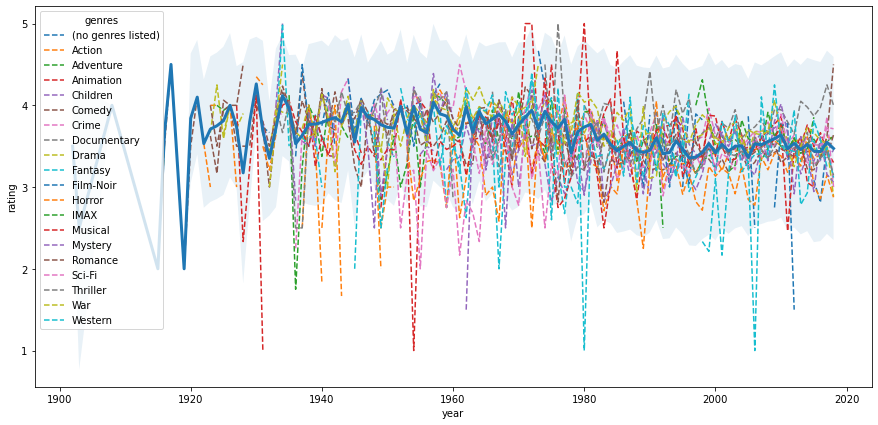

In [71]:
#7. Line chart of average ratings overall and for each genre

year_mean = ratings_df.groupby(['year'])['rating'].mean()
year_std = ratings_df.groupby(['year'])['rating'].std()
year = list(year_mean.index.sort_values())

ratings_df.groupby(['genres','year'])['rating'].mean().unstack(0).plot(kind='line', figsize=(15, 7), linestyle='dashed')

year_mean.plot(kind='line', linewidth=3)
plt.fill_between(year, year_mean - year_std, year_mean + year_std, alpha=0.1)
plt.ylabel('rating')

#Save figure
plt.savefig('plot7.png')

#Show figure
plt.show()

**Findings**

* An upward trend in average ratings is noticed for movies released over the earlier half the twentieth century, and have marginally declined onwards for movies released later. 

* Post 1910, there are more noticeable average ratings across genres falling under the overall average ratings, particularly between 1920 and 1960. Post 1960, average ratings across genres have converged with the marginal overall decline in average ratings. 

## 5. Data Preparation

**5.1.1 Matrix of one-hot-encoded genres**

In [66]:
#Dataframe of one-hot-encoded genres
genres = pd.get_dummies(movies['genres'])

In [67]:
#Concat 'genres' and 'movies'
movies_ = pd.concat([movies, genres], axis=1)

In [68]:
#Drop 'genres' columns
movies_.drop('genres', axis=1, inplace=True)

In [69]:
#Combine one-hot-encoded genres for each movie, unique by movieId
genres_ = movies_.drop(['title','year'], axis=1).groupby(['movieId']).sum().reset_index()
genres_ = genres_.set_index('movieId')
len(genres_)

9737

In [70]:
#Preview
genres_

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193583,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**5.1.2 Dataframe of unique movies**

In [71]:
#Dataframe of unique movies
unique_movies = movies[['movieId','title','year']].drop_duplicates()

In [72]:
#Keep dataframe on unique movies by movieId and title only (exc. year)
unique_movies = unique_movies[['movieId', 'title']]

In [73]:
#Preview
unique_movies

,movieId,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II
...,...,...
9732,193581,Black Butler: Book of the Atlantic
9733,193583,No Game No Life: Zero
9734,193585,Flint
9735,193587,Bungo Stray Dogs: Dead Apple


**5.1.3 Train test split 'ratings'**

* Train test split was used to evaluate the recommenders
* Cross validation was not used due to the lengthy execution time (excluding model-based filtering).

*5.1.3.1 Create train and test set dataframes*

In [74]:
# A reader is still needed but only the rating_scale param is required
reader = Reader(rating_scale=(0.5, 5))

In [75]:
#Train-test split
trainset, testset = train_test_split(ratings, test_size=0.25, stratify=ratings['userId'])

In [76]:
#Check if split is stratified  
list(set(trainset['userId'])) == list(set(testset['userId']))

True

In [77]:
# A reader required to read rating scale between 0.5 and 5
reader = Reader(rating_scale=(0.5, 5))

*5.1.3.2 Create train and tests for Surprise (SVD) to work*

In [78]:
#Train set for surprise (SVD) 
# The columns must correspond to user id, item id and ratings (in that order).
trainset_surprise = Dataset.load_from_df(trainset[['userId', 'movieId', 'rating']], reader)
trainset_surprise = trainset_surprise.build_full_trainset()

In [79]:
#Test set for surprise (SVD)
testset_surprise = list(testset.to_records(index=False))
testset_surprise = [tuple(i)for i in testset_surprise]

**5.1.4 Relevant movies - truths (threshold)**

In [80]:
#Dataframe containing relevant movies only, i.e. 'truths' are seen as ratings > 3.5 (above overall average)  
threshold = testset[testset['rating']>3.5]
threshold = threshold.sort_values(['userId','rating'], ascending=[True,False])

In [81]:
#Convert into list of truths
truths = []
userIds = list(set(ratings['userId']))

for userId in userIds: 
    relevant_ = threshold[threshold['userId']==userId]['movieId'].tolist()
    truths.append(relevant_)

**5.1.5 User-item matrix**

* One for the train set [0]; another for the test set [1]
* Not all movies were rated - movieIds of unseen movies in 'missing_movies' 
* Incorporate unrated movies to user-item matrix 

In [82]:
#Make copies and store train and test sets
datasets = [trainset, testset]

In [83]:
#Lists
userIds = list(set(ratings['userId']))
movieIds = list(set(movies['movieId']))

#Set up user-item matrices and store copies
ui_matrix_ = pd.DataFrame(np.nan, index=userIds, columns=movieIds)

train_ui_ = ui_matrix_.copy()
test_ui_ = ui_matrix_.copy()

ui_matrices = [train_ui_, test_ui_]

#Preview
ui_matrix_

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
#Update user-item matrices
#0 = training set
#1 = test set

for i in 0,1:
    dataset_ui_ = pd.pivot_table(datasets[i], values='rating', index=['userId'], columns=['movieId'])
    ui_matrices[i].update(dataset_ui_)

In [85]:
#Preview of training set user-item matrix
train_ui = ui_matrices[0]
train_ui

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
#Preview of test set user-item matrix
test_ui = ui_matrices[1]
test_ui

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#Check if nulls are
print('Number of not nulls in blank user-item matrix: ', ui_matrix_.notnull().sum().sum())

print('Number of not nulls in training set user-item matrix: ', ui_matrices[0].notnull().sum().sum())
print('Number of not nulls in test set user-item matrix: ', ui_matrices[1].notnull().sum().sum())

print('Number of ratings in total: ', len(ratings))

Number of not nulls in blank user-item matrix:  0
Number of not nulls in training set user-item matrix:  75625
Number of not nulls in test set user-item matrix:  25209
Number of ratings in total:  100834


**5.1.5 Boolean matrices**

Boolean identifier of training set and ratings to be predicted  
1. **'true_ui_bool'**: rated = 1, not rated = 0
2. **'pred_ui_bool'**: rated = 0, not rated = 1

In [88]:
#Matrices
pred_ui_bool = train_ui_.isnull().astype(float) 
true_ui_bool = 1-pred_ui_bool

In [89]:
#Preview
pred_ui_bool

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
607,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
608,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
609,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [90]:
#Preview
true_ui_bool

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
607,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**5.1.6 Store user history, relevant movies and recommendations**

In [91]:
#Dataframe storing each user's history (movies seen and rating); and recommendations (predictions), in later sections
user_movies = []
user_ratings = []

for userId in userIds:
    user_ = pd.DataFrame(train_ui_.loc[userId][train_ui_.loc[userId].notnull()])
    user_ = user_.reset_index()
    user_.columns=['movieId', 'rating']
    movies_ = list(user_['movieId'])
    ratings_ = list(user_['rating'])
    
    user_movies.append(movies_)
    user_ratings.append(ratings_)

In [92]:
#Convert lists to dataframe
user_items = pd.DataFrame([userIds, user_movies, user_ratings, truths]).transpose()

In [93]:
#Name columns
user_items.columns=['userId','movieId','rating','actuals']
#Set index
user_items = user_items.set_index('userId')

In [94]:
#Preview
user_items

,movieId,rating,actuals
userId,,,
1,"[1, 3, 6, 47, 50, 70, 101, 151, 157, 163, 223,...","[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, ...","[2991, 3053, 2459, 1198, 1025, 2502, 608, 5060..."
2,"[318, 333, 131724, 1704, 68157, 71535, 6874, 1...","[3.0, 4.0, 5.0, 4.5, 4.5, 3.0, 4.0, 5.0, 3.5, ...","[89774, 58559, 80489, 74458, 3578]"
3,"[31, 647, 688, 720, 849, 1124, 1263, 1272, 130...","[0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, 0.5, ...","[5919, 5746, 1587, 26409]"
4,"[21, 32, 47, 52, 58, 106, 125, 126, 162, 171, ...","[3.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, 5.0, ...","[920, 2599, 1197, 1080, 3044, 1947, 910, 265, ..."
5,"[34, 36, 58, 153, 232, 247, 261, 266, 290, 296...","[4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 4.0, 1.0, 5.0, ...","[21, 367, 474, 1, 50, 110]"
...,...,...,...
606,"[1, 11, 15, 18, 19, 29, 32, 36, 47, 58, 73, 80...","[2.5, 2.5, 3.5, 4.0, 2.0, 4.5, 4.0, 3.5, 3.0, ...","[1089, 2997, 910, 2360, 2959, 1682, 1193, 3855..."
607,"[1, 11, 25, 112, 153, 165, 188, 204, 208, 241,...","[4.0, 3.0, 3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 3.0, ...","[1370, 2762, 110, 2571, 150, 3347, 1974, 1407,..."
608,"[2, 3, 16, 21, 24, 31, 32, 34, 39, 44, 47, 48,...","[2.0, 2.0, 4.5, 3.5, 2.0, 3.0, 3.5, 3.5, 3.0, ...","[7373, 296, 53996, 3949, 2502, 54503, 6373, 65..."


## 6. Modelling

## Models: 
Examples of two types of recommendation systems were built here.  

1. **Content-based filtering**: using item attributes to make recommendations - built one from scratch using movie genre information (section 6.1)

2. **Collaborative filtering**: two types - memory-based and model-based to understand users' behaviours 
    
    * *Memory-based*: built using the data - both user-based and item-based (memory-based) collaborative filtering were built from scratch 
        * User-based: finds similar users to predict ratings of each users' unseen movies based on historical ratings (section 6.2)
        * Item-based: finds similar items based on historical user ratings to predict unseen movie ratings for each user (section 6.3)
    * *Model-based*: installed the Surprise package to apply the SVD, KNNBasic and KNNWithMeans algorithms to predict unseen movie ratings for each user (section 6.4).

### 6.1 Content-based filtering

*6.1.1 User profiles*

In [95]:
#1. Store user profiles
user_profiles = []

for index in user_items.index: 
    user_movies = user_items['movieId'][index]
    user_rating = user_items['rating'][index]
    
    #Convert list to array
    user_rating = np.array(user_rating)
    #Convert dataframe to a numpy array
    user_genres = genres_.reset_index()[genres_.reset_index()['movieId'].isin(user_movies)]
    user_genres = user_genres.set_index('movieId')
    user_genres = user_genres.to_numpy()

    #Dot product of arrays to compute user profile
    user_profile = user_rating.dot(user_genres)

    #Convert user profile values between 0 and 1
    profile_sum = sum(user_profile)
    user_profile = [x/profile_sum for x in user_profile]
    
    #Append to 'user_profiles'
    user_profiles.append(user_profile)

In [96]:
#Convert to dataframe of user profiles
user_profiles = pd.DataFrame(user_profiles)
user_profiles.shape

(610, 20)

*6.1.2 Compute recommendation scores (between 0 and 1)*

In [97]:
#Create genres matrix (genres x movieIds)
genres_array = genres_.transpose().to_numpy()

In [98]:
#2. Dot product of user profiles and genres to compute recommendation scores
content_rec = pd.DataFrame(np.dot(user_profiles,genres_array))

content_rec.index = userIds
content_rec.index.name = 'userId'

content_rec.columns = movieIds
content_rec.columns.name = 'movieId'

content_rec

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,0.427517,0.266059,0.157552,0.246094,0.115885,0.269097,0.157552,0.194444,0.129774,0.332031,...,0.350260,0.134115,0.204427,0.045573,0.000000,0.362847,0.233073,0.088542,0.175347,0.115885
2,0.151079,0.035971,0.139089,0.323741,0.115108,0.419664,0.139089,0.035971,0.143885,0.309353,...,0.309353,0.184652,0.299760,0.000000,0.057554,0.258993,0.115108,0.184652,0.143885,0.115108
3,0.211679,0.143552,0.085158,0.175182,0.058394,0.330900,0.085158,0.119221,0.160584,0.433090,...,0.445255,0.099757,0.148418,0.009732,0.000000,0.253041,0.092457,0.090024,0.170316,0.058394
4,0.332571,0.125858,0.286804,0.516400,0.193745,0.180015,0.286804,0.087719,0.050343,0.189931,...,0.277651,0.242563,0.423341,0.012967,0.006102,0.295195,0.244851,0.229596,0.063310,0.193745
5,0.360795,0.198864,0.173295,0.406250,0.099432,0.198864,0.173295,0.147727,0.045455,0.156250,...,0.221591,0.295455,0.332386,0.062500,0.000000,0.258523,0.213068,0.232955,0.107955,0.099432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.288769,0.112789,0.289930,0.553696,0.160063,0.177278,0.289930,0.075625,0.058000,0.183495,...,0.263287,0.279683,0.423828,0.015917,0.002254,0.271144,0.213144,0.263766,0.073917,0.160063
607,0.273376,0.157031,0.165596,0.336188,0.104211,0.329764,0.165596,0.118487,0.137045,0.351178,...,0.306210,0.182727,0.274804,0.012134,0.000000,0.291934,0.154889,0.170592,0.149179,0.104211
608,0.325360,0.154248,0.194299,0.324443,0.148016,0.307946,0.194299,0.110072,0.120246,0.314087,...,0.364769,0.153240,0.278160,0.023096,0.003483,0.335533,0.215287,0.130144,0.143342,0.148016


In [99]:
#Unseen movies (predicted)
pred_ui_bool

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
607,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
608,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
609,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [100]:
#3. Only show scores of unseen movies (recommendations only)
rec_scores_df = pred_ui_bool*content_rec
rec_scores_df

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,0.000000,0.266059,0.000000,0.246094,0.115885,0.000000,0.157552,0.194444,0.129774,0.332031,...,0.350260,0.134115,0.204427,0.045573,0.000000,0.362847,0.233073,0.088542,0.175347,0.115885
2,0.151079,0.035971,0.139089,0.323741,0.115108,0.419664,0.139089,0.035971,0.143885,0.309353,...,0.309353,0.184652,0.299760,0.000000,0.057554,0.258993,0.115108,0.184652,0.143885,0.115108
3,0.211679,0.143552,0.085158,0.175182,0.058394,0.330900,0.085158,0.119221,0.160584,0.433090,...,0.445255,0.099757,0.148418,0.009732,0.000000,0.253041,0.092457,0.090024,0.170316,0.058394
4,0.332571,0.125858,0.286804,0.516400,0.193745,0.180015,0.286804,0.087719,0.050343,0.189931,...,0.277651,0.242563,0.423341,0.012967,0.006102,0.295195,0.244851,0.229596,0.063310,0.193745
5,0.360795,0.198864,0.173295,0.406250,0.099432,0.198864,0.173295,0.147727,0.045455,0.156250,...,0.221591,0.295455,0.332386,0.062500,0.000000,0.258523,0.213068,0.232955,0.107955,0.099432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.112789,0.289930,0.553696,0.160063,0.177278,0.289930,0.075625,0.058000,0.183495,...,0.263287,0.279683,0.423828,0.015917,0.000000,0.271144,0.213144,0.263766,0.073917,0.160063
607,0.000000,0.157031,0.165596,0.336188,0.104211,0.329764,0.165596,0.118487,0.137045,0.351178,...,0.306210,0.182727,0.274804,0.012134,0.000000,0.291934,0.154889,0.170592,0.149179,0.104211
608,0.325360,0.000000,0.000000,0.324443,0.148016,0.307946,0.194299,0.110072,0.120246,0.314087,...,0.364769,0.153240,0.278160,0.023096,0.003483,0.335533,0.215287,0.130144,0.143342,0.148016
609,0.162896,0.085973,0.149321,0.361991,0.076923,0.389140,0.149321,0.085973,0.126697,0.000000,...,0.257919,0.212670,0.289593,0.000000,0.027149,0.203620,0.076923,0.212670,0.126697,0.076923


*6.1.3 Recommendations - ordered and stored*

In [101]:
#Store ordered recommendations
rec_ordered_scores = []

for userId in userIds:
    rec_ordered_scores_ = list(rec_scores_df.loc[userId].sort_values(ascending=False).index)
    rec_ordered_scores.append(rec_ordered_scores_)

In [102]:
#Convert dataframe to lists for each user
rec_ordered = pd.DataFrame(rec_ordered_scores).values.tolist()

In [103]:
#Store recommendations to new column in user_items
user_items['content_based_rec']=rec_ordered

In [104]:
#Preview
user_items

,movieId,rating,actuals,content_based_rec
userId,,,,
1,"[1, 3, 6, 47, 50, 70, 101, 151, 157, 163, 223,...","[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, ...","[2991, 3053, 2459, 1198, 1025, 2502, 608, 5060...","[180497, 26171, 178615, 74647, 128852, 4298, 5..."
2,"[318, 333, 131724, 1704, 68157, 71535, 6874, 1...","[3.0, 4.0, 5.0, 4.5, 4.5, 3.0, 4.0, 5.0, 3.5, ...","[89774, 58559, 80489, 74458, 3578]","[180497, 4105, 81784, 71530, 4366, 20, 5771, 4..."
3,"[31, 647, 688, 720, 849, 1124, 1263, 1272, 130...","[0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, 0.5, ...","[5919, 5746, 1587, 26409]","[178615, 172233, 44511, 171811, 5325, 140816, ..."
4,"[21, 32, 47, 52, 58, 106, 125, 126, 162, 171, ...","[3.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, 5.0, ...","[920, 2599, 1197, 1080, 3044, 1947, 910, 265, ...","[180497, 4105, 4298, 5670, 73042, 6319, 26171,..."
5,"[34, 36, 58, 153, 232, 247, 261, 266, 290, 296...","[4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 4.0, 1.0, 5.0, ...","[21, 367, 474, 1, 50, 110]","[1635, 4105, 122932, 180497, 27370, 7301, 6319..."
...,...,...,...,...
606,"[1, 11, 15, 18, 19, 29, 32, 36, 47, 58, 73, 80...","[2.5, 2.5, 3.5, 4.0, 2.0, 4.5, 4.0, 3.5, 3.0, ...","[1089, 2997, 910, 2360, 2959, 1682, 1193, 3855...","[4105, 4298, 180497, 6994, 3445, 5009, 1642, 8..."
607,"[1, 11, 25, 112, 153, 165, 188, 204, 208, 241,...","[4.0, 3.0, 3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 3.0, ...","[1370, 2762, 110, 2571, 150, 3347, 1974, 1407,...","[180497, 4298, 4105, 178615, 71530, 26171, 422..."
608,"[2, 3, 16, 21, 24, 31, 32, 34, 39, 44, 47, 48,...","[2.0, 2.0, 4.5, 3.5, 2.0, 3.0, 3.5, 3.5, 3.0, ...","[7373, 296, 53996, 3949, 2502, 54503, 6373, 65...","[180497, 4298, 26171, 71530, 5670, 178615, 141..."


**Findings**
* Top recommendations tend to favour movies that are categorised under more genres
* This is sensible as content-based filtering techniques resolve cold starts. 

### 6.2 Collaborative-based filtering

#### 6.2.1 User-User collaberative filtering

*6.2.1.1 Normalise ratings*

* Normalised to help determine if a user sees the movies as above or below average by their standards (e.g. some users rate more optimistically and pessismistically, while others have greater range). 

* Movies that are not viewed yet are not valued as zero, and are predicted here. Thus, normalisation for ratings to centre around 0 is sensible.

In [105]:
#1. Calculate mean of ratings for each user  
rating_means = train_ui.mean(axis=1)

#2. Store normalised ratings
normalised_ratings = [] 

for userId in userIds:
    normalised_rating_ = train_ui.loc[userId] - rating_means.loc[userId]
    normalised_ratings.append(normalised_rating_)

normalised_ratings = pd.DataFrame(normalised_ratings)

#3. Set column and index names
normalised_ratings.index.name = 'userId'
normalised_ratings.columns.name = 'movieId'

In [106]:
#with nulls
normalised_ratings_w_nulls = normalised_ratings.copy()

In [107]:
#Fill nulls with zero after normalisation
normalised_ratings = normalised_ratings.fillna(0)

In [108]:
#Preview
normalised_ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.385057,0.000000,-0.385057,0.0,0.0,-0.385057,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.166866,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.333134,0.0,0.0,0.0,0.000000,0.0
607,0.285714,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
608,0.000000,-1.162119,-1.162119,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [109]:
#Preview
normalised_ratings_w_nulls

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.385057,NaN,-0.385057,NaN,NaN,-0.385057,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.166866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.333134,NaN,NaN,NaN,NaN,NaN
607,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,-1.162119,-1.162119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*6.2.1.2 User Similarities*

6.2.1.2.1 *Check rating deviations*

Pearson correlations work when there is deviation in ratings. Intuitively, a range of ratings indicate movie preferences; otherwise a user is indifferent to movie preferences. It informs and help gauge a differentiation between a good movie and a bad movie, and to what extent. 

In [110]:
#Check for sum of normalised ratings > 0
check_ratings = []

for userId in userIds:
    if ratings[ratings['userId']==userId]['rating'].value_counts().count()<2:
        print('Check userId: ', userId)
        check_ratings.append(userId)
    else:
        ''

Check userId:  53


In [111]:
#Check ratings
ratings[ratings['userId'].isin(check_ratings)]['rating'].value_counts()

5.0    20
Name: rating, dtype: int64

**Findings**
* userId 53 rated all 20 movies 5 out of 5
* userId 53 will return NaNs in Pearson correlation computations
* userId 53 provides no new information on user preferences/behaviours due to the user's indifference in movie ratings

6.2.1.2.2 *Calculate user similarities*

In [112]:
#Pearson correlations
user_similarities = []

for i in userIds:
    user_corr = []
    for j in userIds:
        corr_ = pearsonr(normalised_ratings.loc[i],normalised_ratings.loc[j])[0]
        user_corr.append(corr_)
    user_similarities.append(user_corr)

C:\Users\61406\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [113]:
#Convert to dataframe
user_similarities = pd.DataFrame(user_similarities)

In [114]:
user_similarities.isnull().sum().sort_values()

0        1
402      1
403      1
404      1
405      1
      ... 
206      1
207      1
201      1
609      1
52     610
Length: 610, dtype: int64

6.2.1.2.3 *Fill null user similarities*

In [115]:
#Find nulls in dataframe
user_similarities.isnull().sum()

0      1
1      1
2      1
3      1
4      1
      ..
605    1
606    1
607    1
608    1
609    1
Length: 610, dtype: int64

In [116]:
#Check number of nulls
print('Total number of nulls: ', user_similarities.isnull().sum(axis=1).sum())
print('Value counts of nulls: \n', user_similarities.isnull().sum(axis=1).value_counts())

Total number of nulls:  1219
Value counts of nulls: 
 1      609
610      1
dtype: int64


**Findings**
* userId 53 has 610 null correlations (vertically & horizontally in dataframe)
* total number of nulls = 610*2-1 = 1219

**Actions**
* Fill nulls with 0 

In [117]:
#Fill nulls with 0
user_similarities = user_similarities.fillna(0)

#Update index and columns

user_similarities.index = userIds
user_similarities.columns = userIds

user_similarities.index.name = 'userIds'
user_similarities.columns.name = 'userIds'

In [118]:
#Preview user similarities
user_similarities

userIds,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userIds,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.615434e-03,-6.318708e-03,1.828774e-02,5.603423e-02,-0.028889,9.671685e-03,6.766397e-02,5.353285e-04,-2.263391e-02,...,3.236472e-02,0.002968,0.002243,-1.196570e-02,-1.313124e-02,0.016102,2.435203e-02,0.107272,4.251191e-03,0.011527
2,0.001615,1.000000e+00,-4.513898e-35,3.686350e-35,2.542764e-02,0.003308,-8.518045e-03,-5.196871e-02,1.278938e-35,-6.353784e-02,...,-1.807842e-02,-0.038477,-0.002468,-2.287042e-34,4.092601e-34,0.008833,1.685189e-34,-0.001660,-6.628360e-02,0.023361
3,-0.006319,-4.513898e-35,1.000000e+00,3.654364e-35,-4.098493e-35,-0.000939,5.416678e-35,-5.318267e-35,1.733949e-36,-3.761582e-36,...,1.776227e-02,0.004590,0.022816,-1.511247e-34,7.748859e-35,0.000005,1.080314e-02,0.003399,-7.211255e-35,0.029982
4,0.018288,3.686350e-35,3.654364e-35,1.000000e+00,-3.336326e-02,0.018598,5.230248e-02,-1.133821e-02,-7.048002e-03,9.665912e-03,...,-2.477404e-02,0.072829,0.014085,7.902661e-03,2.231985e-02,0.032564,4.089282e-02,-0.008902,-1.787155e-02,-0.004251
5,0.056034,2.542764e-02,-4.098493e-35,-3.336326e-02,1.000000e+00,0.028707,1.089367e-02,1.182241e-01,-1.535312e-35,-3.775457e-02,...,3.051987e-02,0.014795,0.030204,-2.804402e-02,-3.092576e-02,0.038217,5.155087e-02,-0.025981,7.207746e-02,-0.000284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.016102,8.833356e-03,4.926441e-06,3.256361e-02,3.821700e-02,-0.007565,2.193672e-02,2.007403e-02,1.774640e-02,-2.420765e-02,...,5.000223e-02,0.023463,0.065272,5.132527e-02,2.574945e-02,1.000000,8.166729e-03,0.052939,2.439657e-02,0.046689
607,0.024352,1.685189e-34,1.080314e-02,4.089282e-02,5.155087e-02,0.036179,1.246286e-02,4.433178e-02,-1.484652e-02,2.209462e-02,...,2.259113e-02,0.004208,0.050606,4.430220e-02,-2.513719e-02,0.008167,1.000000e+00,0.013151,1.957600e-02,0.023596
608,0.107272,-1.659508e-03,3.398883e-03,-8.902211e-03,-2.598103e-02,0.003889,1.559926e-02,7.319227e-02,3.318073e-02,-3.520659e-02,...,4.452665e-02,0.020984,0.014040,8.873150e-03,1.949298e-02,0.052939,1.315068e-02,1.000000,2.164201e-02,0.051196


6.2.1.2.4 *Check user similarities*

In [119]:
#Check for nulls
user_similarities.isnull().sum().sum()!=0

False

In [120]:
#Number of ratings not in between 0 to 5 
print('Number of user correlations less than -1: ', sum([user_similarities < -1]).sum().sum())
print('Number of user correlations greater than 1: ', sum([user_similarities > 1]).sum().sum())

Number of user correlations less than -1:  0
Number of user correlations greater than 1:  0


*6.2.1.3 Caluculate rating predictions (between 0 and 5)*

**Predicted ratings = average ratings (by user) + adjustments**

Where adjustments = numerator/denominator: 
* Numerator: dot product of user similarities and normalised ratings
* Denominator: summation of user similarities (absolute values)

In [121]:
#Numerator of adjustment for ratings
weighted_rating_u = pd.DataFrame(np.dot(user_similarities,normalised_ratings))

weighted_rating_u.index = userIds
weighted_rating_u.index.name = 'userId'
weighted_rating_u.columns = movieIds
weighted_rating_u.columns.name = 'movieId'

#Preview
weighted_rating_u

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,0.652009,-0.697409,-0.749850,-0.067351,-0.661772,-0.241028,-0.401265,-0.073209,-0.181749,-0.499359,...,-0.017533,-0.014908,-0.004591,0.0,0.005364,-0.005452,-0.011513,0.005566,0.037954,-0.051928
2,-0.144126,-0.033969,-0.037937,0.040603,0.142264,-0.135942,-0.071987,-0.001383,0.032114,0.254478,...,-0.036872,-0.003898,0.098878,0.0,0.002943,0.001087,-0.001740,0.000242,-0.028157,-0.002257
3,-0.105005,0.100725,0.041120,0.016098,0.100722,0.145483,0.135665,-0.013873,-0.032059,0.079035,...,-0.001650,-0.013674,-0.003807,0.0,0.000002,-0.000488,-0.014720,-0.001464,0.031332,0.013655
4,0.289239,-0.082824,-0.070554,-0.006864,-0.261017,-0.160718,-0.279042,-0.002054,-0.039449,0.041584,...,0.005639,0.018666,-0.014607,0.0,0.010848,-0.003773,0.010007,0.004154,0.003519,-0.038754
5,1.733189,-0.132634,0.014775,0.006698,-0.210185,0.424070,0.008398,-0.073036,-0.111828,-0.821979,...,0.009690,-0.023342,-0.014238,0.0,0.012731,-0.000558,0.004073,0.000489,0.033239,-0.004564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-0.475618,-0.802241,-0.134736,-0.104610,-1.138027,0.968195,-0.516086,-0.130193,-0.114075,-0.366472,...,-0.065173,-0.086576,-0.032608,0.0,0.333134,-0.007162,-0.019227,0.005484,0.111081,-0.051162
607,1.058226,0.113708,0.421936,0.213817,-0.032823,0.192666,-0.028252,-0.146396,-0.034565,-0.248021,...,-0.004251,-0.053282,-0.060833,0.0,0.002721,0.004549,0.000303,0.001443,0.019356,-0.013459
608,1.676425,-1.975835,-1.763991,-0.122199,-0.998372,1.313040,-0.664952,-0.051811,-0.312785,0.243860,...,-0.089530,-0.055380,-0.097527,0.0,0.017636,-0.018460,-0.038622,0.003962,0.107328,-0.036961


In [122]:
#Denominator of adjustment for ratings
sum_weights_u_ = abs(user_similarities).sum()
sum_weights_u_

#Dataframe for denominator
sum_weights_u = ui_matrix_.copy()

for userId in userIds: 
    sum_weights_u.loc[userId]=sum_weights_u_[userId]
    
sum_weights_u.index = userIds
sum_weights_u.index.name = 'userId'
sum_weights_u.columns = movieIds
sum_weights_u.columns.name = 'movieId'

#Preview
sum_weights_u

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,...,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826,15.364826
2,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,...,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133,10.026133
3,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,...,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695,4.672695
4,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,...,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579,13.406579
5,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,...,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650,19.426650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,...,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286,18.516286
607,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,...,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351,15.096351
608,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,...,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528,19.412528


In [123]:
#Calculate adjustments to each user's average rating 
add_weighted_rating = weighted_rating_u/sum_weights_u

add_weighted_rating.index = userIds
add_weighted_rating.index.name = 'userIds'
add_weighted_rating.columns = movieIds
add_weighted_rating.columns.name = 'movieId'
add_weighted_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userIds,,,,,,,,,,,,,,,,,,,,,
1,0.042435,-0.045390,-0.048803,-0.004383,-0.043071,-0.015687,-0.026116,-0.004765,-0.011829,-0.032500,...,-0.001141,-0.000970,-0.000299,0.0,3.491252e-04,-0.000355,-0.000749,0.000362,0.002470,-0.003380
2,-0.014375,-0.003388,-0.003784,0.004050,0.014189,-0.013559,-0.007180,-0.000138,0.003203,0.025381,...,-0.003678,-0.000389,0.009862,0.0,2.935021e-04,0.000108,-0.000174,0.000024,-0.002808,-0.000225
3,-0.022472,0.021556,0.008800,0.003445,0.021555,0.031135,0.029033,-0.002969,-0.006861,0.016914,...,-0.000353,-0.002926,-0.000815,0.0,3.512245e-07,-0.000104,-0.003150,-0.000313,0.006705,0.002922
4,0.021574,-0.006178,-0.005263,-0.000512,-0.019469,-0.011988,-0.020814,-0.000153,-0.002943,0.003102,...,0.000421,0.001392,-0.001090,0.0,8.091583e-04,-0.000281,0.000746,0.000310,0.000262,-0.002891
5,0.089217,-0.006827,0.000761,0.000345,-0.010819,0.021829,0.000432,-0.003760,-0.005756,-0.042312,...,0.000499,-0.001202,-0.000733,0.0,6.553565e-04,-0.000029,0.000210,0.000025,0.001711,-0.000235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-0.025686,-0.043326,-0.007277,-0.005650,-0.061461,0.052289,-0.027872,-0.007031,-0.006161,-0.019792,...,-0.003520,-0.004676,-0.001761,0.0,1.799140e-02,-0.000387,-0.001038,0.000296,0.005999,-0.002763
607,0.070098,0.007532,0.027950,0.014163,-0.002174,0.012762,-0.001871,-0.009697,-0.002290,-0.016429,...,-0.000282,-0.003529,-0.004030,0.0,1.802167e-04,0.000301,0.000020,0.000096,0.001282,-0.000892
608,0.086358,-0.101781,-0.090869,-0.006295,-0.051429,0.067639,-0.034254,-0.002669,-0.016113,0.012562,...,-0.004612,-0.002853,-0.005024,0.0,9.084704e-04,-0.000951,-0.001990,0.000204,0.005529,-0.001904


In [124]:
#Store calculated ratings 
predicted_rating_u = []

for userId in userIds:
    predicted_rating_ = add_weighted_rating.loc[userId]+rating_means.loc[userId]
    predicted_rating_u.append(predicted_rating_)

In [125]:
#Convert to dataframe
predicted_rating_u = pd.DataFrame(predicted_rating_u)

predicted_rating_u.index = userIds
predicted_rating_u.index.name = 'userId'
predicted_rating_u.columns = movieIds
predicted_rating_u.columns.name = 'movieId'

In [126]:
#Predicted ratings for all movies and for all users
predicted_rating_u

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,4.427493,4.339667,4.336254,4.380674,4.341987,4.369370,4.358942,4.380293,4.373229,4.352557,...,4.383916,4.384087,4.384759,4.385057,4.385407,4.384703,4.384308,4.385420,4.387528,4.381678
2,3.871989,3.882976,3.882580,3.890413,3.900553,3.872805,3.879184,3.886226,3.889567,3.911745,...,3.882686,3.885975,3.896226,3.886364,3.886657,3.886472,3.886190,3.886388,3.883555,3.886138
3,2.391321,2.435349,2.422593,2.417238,2.435348,2.444928,2.442827,2.410824,2.406932,2.430707,...,2.413440,2.410867,2.412978,2.413793,2.413793,2.413689,2.410643,2.413480,2.420498,2.416715
4,3.527747,3.499995,3.500910,3.505661,3.486703,3.494185,3.485359,3.506020,3.503230,3.509275,...,3.506593,3.507565,3.505083,3.506173,3.506982,3.505891,3.506919,3.506483,3.506435,3.503282
5,3.786187,3.690142,3.697730,3.697314,3.686150,3.718799,3.697402,3.693210,3.691213,3.654658,...,3.697469,3.695768,3.696237,3.696970,3.697625,3.696941,3.697179,3.696995,3.698681,3.696735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.641180,3.623540,3.659589,3.661216,3.605405,3.719155,3.638994,3.659835,3.660705,3.647074,...,3.663346,3.662190,3.665105,3.666866,3.684857,3.666479,3.665828,3.667162,3.672865,3.664103
607,3.784384,3.721818,3.742235,3.728449,3.712111,3.727048,3.712414,3.704588,3.711996,3.697857,...,3.714004,3.710756,3.710256,3.714286,3.714466,3.714587,3.714306,3.714381,3.715568,3.713394
608,3.248477,3.060337,3.071250,3.155824,3.110690,3.229758,3.127865,3.159450,3.146006,3.174681,...,3.157507,3.159266,3.157095,3.162119,3.163027,3.161168,3.160129,3.162323,3.167648,3.160215


*6.2.1.4 Rating predictions for unseen movies only (between 0 and 5)*

In [127]:
#Return prediction ratings for unseen movies only
user_user_rec = predicted_rating_u*pred_ui_bool
user_user_rec

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,4.339667,0.000000,4.380674,4.341987,0.000000,4.358942,4.380293,4.373229,4.352557,...,4.383916,4.384087,4.384759,4.385057,4.385407,4.384703,4.384308,4.385420,4.387528,4.381678
2,3.871989,3.882976,3.882580,3.890413,3.900553,3.872805,3.879184,3.886226,3.889567,3.911745,...,3.882686,3.885975,3.896226,3.886364,3.886657,3.886472,3.886190,3.886388,3.883555,3.886138
3,2.391321,2.435349,2.422593,2.417238,2.435348,2.444928,2.442827,2.410824,2.406932,2.430707,...,2.413440,2.410867,2.412978,2.413793,2.413793,2.413689,2.410643,2.413480,2.420498,2.416715
4,3.527747,3.499995,3.500910,3.505661,3.486703,3.494185,3.485359,3.506020,3.503230,3.509275,...,3.506593,3.507565,3.505083,3.506173,3.506982,3.505891,3.506919,3.506483,3.506435,3.503282
5,3.786187,3.690142,3.697730,3.697314,3.686150,3.718799,3.697402,3.693210,3.691213,3.654658,...,3.697469,3.695768,3.696237,3.696970,3.697625,3.696941,3.697179,3.696995,3.698681,3.696735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,3.623540,3.659589,3.661216,3.605405,3.719155,3.638994,3.659835,3.660705,3.647074,...,3.663346,3.662190,3.665105,3.666866,0.000000,3.666479,3.665828,3.667162,3.672865,3.664103
607,0.000000,3.721818,3.742235,3.728449,3.712111,3.727048,3.712414,3.704588,3.711996,3.697857,...,3.714004,3.710756,3.710256,3.714286,3.714466,3.714587,3.714306,3.714381,3.715568,3.713394
608,3.248477,0.000000,0.000000,3.155824,3.110690,3.229758,3.127865,3.159450,3.146006,3.174681,...,3.157507,3.159266,3.157095,3.162119,3.163027,3.161168,3.160129,3.162323,3.167648,3.160215


*6.2.1.5 Order and store recommendations to 'user_items'*

In [128]:
#Store ordered recommendations
user_user_rec_ordered = []

for userId in userIds:
    rec_ = list(user_user_rec.loc[userId].sort_values(ascending=False).index)
    user_user_rec_ordered.append(rec_)

In [129]:
#Convert to list to store
user_user_rec_ordered = pd.DataFrame(user_user_rec_ordered)
user_user_rec_ordered = user_user_rec_ordered.values.tolist()

In [130]:
#Store recommendations
user_items['user_user_rec']=user_user_rec_ordered

*6.2.1.6 Ensure valid rating predictions*

In [131]:
#Number of ratings not in between 0 to 5 
print('Number of predicted ratings less than 0: ', sum([predicted_rating_u < 0]).sum().sum())
print('Number of predicted ratings greater than 5: ', sum([predicted_rating_u > 5]).sum().sum())

Number of predicted ratings less than 0:  0
Number of predicted ratings greater than 5:  38


In [132]:
#Convert predicted ratings greater than 5 to equal 5
predicted_rating_u[predicted_rating_u > 5] = 5

C:\Users\61406\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


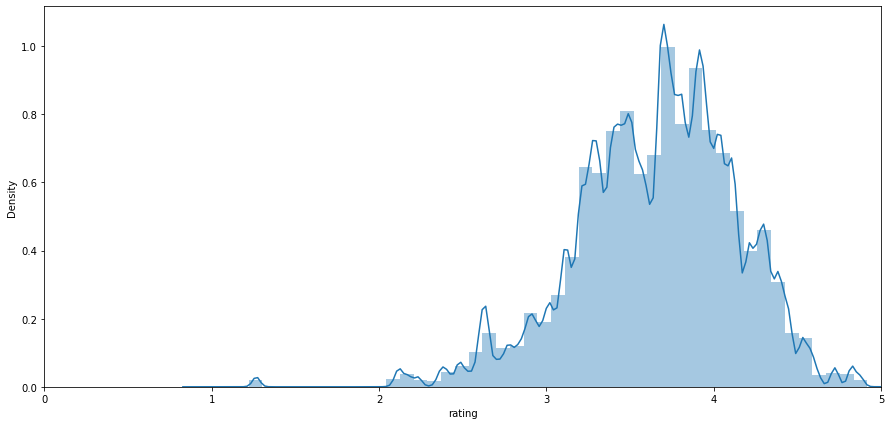

In [133]:
#Check ratings
plt.figure(figsize=(15,7))
sns.distplot(list(predicted_rating_u.stack()))
plt.xlim(0,5)
plt.xlabel('rating')
plt.savefig('uu_pred.png')
plt.show()

In [134]:
#Preview of updated predicted ratings
predicted_rating_u

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,4.427493,4.339667,4.336254,4.380674,4.341987,4.369370,4.358942,4.380293,4.373229,4.352557,...,4.383916,4.384087,4.384759,4.385057,4.385407,4.384703,4.384308,4.385420,4.387528,4.381678
2,3.871989,3.882976,3.882580,3.890413,3.900553,3.872805,3.879184,3.886226,3.889567,3.911745,...,3.882686,3.885975,3.896226,3.886364,3.886657,3.886472,3.886190,3.886388,3.883555,3.886138
3,2.391321,2.435349,2.422593,2.417238,2.435348,2.444928,2.442827,2.410824,2.406932,2.430707,...,2.413440,2.410867,2.412978,2.413793,2.413793,2.413689,2.410643,2.413480,2.420498,2.416715
4,3.527747,3.499995,3.500910,3.505661,3.486703,3.494185,3.485359,3.506020,3.503230,3.509275,...,3.506593,3.507565,3.505083,3.506173,3.506982,3.505891,3.506919,3.506483,3.506435,3.503282
5,3.786187,3.690142,3.697730,3.697314,3.686150,3.718799,3.697402,3.693210,3.691213,3.654658,...,3.697469,3.695768,3.696237,3.696970,3.697625,3.696941,3.697179,3.696995,3.698681,3.696735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.641180,3.623540,3.659589,3.661216,3.605405,3.719155,3.638994,3.659835,3.660705,3.647074,...,3.663346,3.662190,3.665105,3.666866,3.684857,3.666479,3.665828,3.667162,3.672865,3.664103
607,3.784384,3.721818,3.742235,3.728449,3.712111,3.727048,3.712414,3.704588,3.711996,3.697857,...,3.714004,3.710756,3.710256,3.714286,3.714466,3.714587,3.714306,3.714381,3.715568,3.713394
608,3.248477,3.060337,3.071250,3.155824,3.110690,3.229758,3.127865,3.159450,3.146006,3.174681,...,3.157507,3.159266,3.157095,3.162119,3.163027,3.161168,3.160129,3.162323,3.167648,3.160215


### 6.3 Item-item collaborative-based filtering

*6.3.1 Item similarities (cosine similarities)*

In [135]:
#Item similarities
item_similarities = []
train_ui_i = train_ui.fillna(0)

for movieId_i in movieIds:
    cos_sim_i = []
    movie_i = train_ui_i[movieId_i].to_numpy().reshape(-1,1).transpose()

    for movieId_j in movieIds:
        movie_j = train_ui_i[movieId_j].to_numpy().reshape(-1,1).transpose()
        cos_sim_ = cosine_similarity(movie_i, movie_j)[0][0]
        cos_sim_i.append(cos_sim_)   

    item_similarities.append(cos_sim_i)

In [136]:
#Convert to dataframe
item_similarities = pd.DataFrame(item_similarities)

item_similarities.index = movieIds
item_similarities.index.name = 'movieId'

item_similarities.columns = movieIds
item_similarities.columns.name = 'movieId'

In [137]:
#Preview 
item_similarities

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.321630,0.248469,0.000000,0.254341,0.222876,0.215922,0.090063,0.154768,0.262416,...,0.080513,0.022802,0.029119,0.0,0.050321,0.0,0.000000,0.100641,0.069423,0.100641
2,0.321630,1.000000,0.259464,0.033346,0.234017,0.210650,0.194477,0.013236,0.000000,0.280765,...,0.122269,0.076183,0.064631,0.0,0.000000,0.0,0.152837,0.091702,0.162096,0.091702
3,0.248469,0.259464,1.000000,0.000000,0.310426,0.164893,0.343764,0.180705,0.192529,0.167330,...,0.000000,0.034039,0.033437,0.0,0.000000,0.0,0.000000,0.150235,0.000000,0.150235
4,0.000000,0.033346,0.000000,1.000000,0.122820,0.127152,0.254403,0.236189,0.000000,0.058365,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,0.254341,0.234017,0.310426,0.122820,1.000000,0.189118,0.415014,0.000000,0.168044,0.134512,...,0.000000,0.036012,0.138554,0.0,0.000000,0.0,0.000000,0.158944,0.000000,0.158944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119591,0.000000,0.144171,0.102138,...,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
32743,0.000000,0.152837,0.000000,0.000000,0.000000,0.145695,0.000000,0.000000,0.000000,0.145912,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.431131,0.000000
98279,0.100641,0.091702,0.150235,0.000000,0.158944,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.226572,0.222566,0.0,0.000000,0.0,0.000000,1.000000,0.000000,1.000000


*6.3.2 Check item similarities*

In [138]:
#Check for nulls
item_similarities.isnull().sum().sum()!=0

False

In [139]:
#Number of ratings not in between 0 to 5 
print('Number of item similarities less than 0: ', sum([item_similarities < 0]).sum().sum())
print('Number of item similarities greater than 1: ', sum([item_similarities > 1]).sum().sum())

Number of item similarities less than 0:  0
Number of item similarities greater than 1:  876


In [140]:
#Largest value in item_similarities
item_similarities.max().max()

1.0000000000000004

*6.3.3 Calculate rating predictions*

Predicted ratings is equal to a) the dot product of user ratings and item similarities, divided by b) the summation of item correlations.

In [141]:
#Numerator component
weighted_rating_i = pd.DataFrame(np.dot(train_ui_i, item_similarities))

weighted_rating_i.index = userIds
weighted_rating_i.index.name = 'userId'
weighted_rating_i.columns = movieIds
weighted_rating_i.columns.name = 'movieId'

weighted_rating_i

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,169.415084,149.932156,133.052763,20.598299,84.616663,156.203362,85.434271,38.330718,17.406725,137.935542,...,26.607464,24.253693,30.990184,0.0,26.684950,55.350307,57.219868,48.364540,59.899725,48.364540
2,13.185632,12.507992,5.308413,0.760014,6.953036,9.413795,4.761327,2.911838,0.986096,8.743958,...,7.723986,5.002848,11.750346,0.0,1.468246,6.385897,2.655643,6.104908,11.904859,6.104908
3,6.308494,5.723100,4.793556,1.039709,3.445979,5.784737,2.917850,1.497751,1.104710,5.224984,...,0.284507,0.850350,1.008695,0.0,0.626910,3.315593,3.130376,3.225516,4.701945,3.225516
4,88.887856,76.094902,49.502207,23.606318,50.867995,85.782371,59.237224,17.827741,9.932351,71.362966,...,13.988344,12.175343,15.558164,0.0,35.980707,39.862528,12.841479,24.283037,25.828060,24.283037
5,29.614353,29.382208,18.376910,14.779517,19.405112,25.752636,21.291447,13.100766,3.218636,29.896362,...,2.850759,2.782919,3.160194,0.0,8.221318,5.895370,4.980403,4.316666,6.065061,4.316666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,414.103994,328.373783,197.730067,72.874021,216.219874,314.281592,230.883990,62.085827,33.493787,271.652401,...,73.116546,67.218466,85.920080,0.0,1266.909595,163.560245,80.484036,115.540254,158.515091,115.540254
607,118.799722,101.470921,70.972004,18.898753,59.066766,97.696692,61.042583,29.733597,11.039724,95.736583,...,16.242029,15.276952,20.494175,0.0,20.768761,38.637999,26.011045,28.874304,35.614548,28.874304
608,352.792264,367.154317,252.531678,46.920590,202.693805,303.616552,199.241705,101.655955,48.045730,310.573035,...,92.529357,60.822584,103.430517,0.0,70.711328,161.643235,145.442576,126.183550,186.829702,126.183550


In [142]:
#Denominator of adjustment for ratings
sum_weights_i = np.dot(true_ui_bool, item_similarities)
sum_weights_i = pd.DataFrame(sum_weights_i)

sum_weights_i.index = userIds
sum_weights_i.index.name = 'userId'
sum_weights_i.columns = movieIds
sum_weights_i.columns.name = 'movieId'

#Preview
sum_weights_i

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,38.509924,34.093912,30.350318,4.683586,19.301387,35.570475,19.609655,8.814171,4.162371,31.547014,...,6.173205,5.312821,7.041719,0.0,5.904280,12.722010,12.755141,10.914911,13.292313,10.914911
2,3.454768,3.307077,1.460525,0.205992,1.832495,2.478516,1.274165,0.757461,0.263167,2.300287,...,1.927027,1.368707,2.866659,0.0,0.367305,1.674092,0.741349,1.862860,3.012903,1.862860
3,3.772780,3.529894,2.686152,1.410893,2.321504,3.204963,2.332360,0.920337,0.582953,2.830234,...,0.142254,0.491782,0.806098,0.0,1.253821,1.768512,1.422419,1.755472,1.987691,1.755472
4,25.745289,22.126480,14.369119,6.896546,14.444218,24.801720,17.104422,5.706362,2.972193,21.200016,...,3.975456,3.577008,4.311678,0.0,9.869314,11.032259,4.004655,6.609655,7.379826,6.609655
5,8.078416,8.219237,5.203001,4.141481,5.356083,7.142666,5.909631,3.541559,0.859860,8.515153,...,0.814025,0.860860,0.910622,0.0,2.095834,1.645622,1.393117,1.323062,1.713113,1.323062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,112.930995,91.167944,55.900837,19.476527,59.954471,84.180219,63.001854,17.824571,9.471770,75.137267,...,22.036033,18.844113,24.546762,0.0,341.727250,46.459516,22.882383,34.947844,42.644969,34.947844
607,32.065082,27.456625,19.096071,5.087073,15.973816,26.200530,16.562388,7.949148,3.210522,25.862611,...,4.549598,4.399157,5.709147,0.0,5.552192,10.860494,7.011143,7.589625,9.553420,7.589625
608,109.030085,114.652995,81.652349,17.136514,65.001447,91.514616,65.424826,34.349724,17.351457,96.192140,...,26.563056,18.492909,31.153797,0.0,21.046089,54.272771,46.337669,41.396649,54.958338,41.396649


In [143]:
#Predicted ratings dataframe
predicted_rating_i = weighted_rating_i/sum_weights_i

#fillna(0): for dividing zeroes from 'sum_weights_i'
predicted_rating_i = predicted_rating_i.fillna(0)

predicted_rating_i.index = userIds
predicted_rating_i.index.name = 'userId'
predicted_rating_i.columns = movieIds
predicted_rating_i.columns.name = 'movieId'

In [144]:
#Predicted ratings for all movies
predicted_rating_i

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,4.399258,4.397623,4.383900,4.397976,4.383968,4.391377,4.356745,4.348761,4.181925,4.372380,...,4.310154,4.565125,4.400940,0.0,4.519594,4.350752,4.486024,4.431052,4.506343,4.431052
2,3.816648,3.782189,3.634592,3.689522,3.794300,3.798158,3.736820,3.844211,3.747030,3.801246,...,4.008239,3.655164,4.098969,0.0,3.997348,3.814542,3.582178,3.277170,3.951292,3.277170
3,1.672108,1.621323,1.784543,0.736915,1.484373,1.804931,1.251029,1.627394,1.895025,1.846131,...,2.000000,1.729122,1.251330,0.0,0.500000,1.874792,2.200741,1.837407,2.365532,1.837407
4,3.452587,3.439087,3.445041,3.422919,3.521686,3.458727,3.463270,3.124187,3.341759,3.366175,...,3.518677,3.403778,3.608378,0.0,3.645715,3.613270,3.206638,3.673874,3.499820,3.673874
5,3.665861,3.574810,3.531982,3.568655,3.623004,3.605466,3.602839,3.699152,3.743209,3.510960,...,3.502052,3.232720,3.470367,0.0,3.922695,3.582456,3.575006,3.262633,3.540373,3.262633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.666876,3.601856,3.537158,3.741633,3.606401,3.733438,3.664717,3.483160,3.536170,3.615415,...,3.318045,3.567080,3.500261,0.0,3.707371,3.520490,3.517293,3.306077,3.717088,3.306077
607,3.704956,3.695681,3.716576,3.715055,3.697724,3.728806,3.685615,3.740476,3.438607,3.701737,...,3.569992,3.472700,3.589709,0.0,3.740642,3.557665,3.709958,3.804444,3.727937,3.804444
608,3.235733,3.202309,3.092767,2.738047,3.118297,3.317684,3.045353,2.959440,2.768974,3.228674,...,3.483385,3.288968,3.319997,0.0,3.359832,2.978349,3.138755,3.048159,3.399479,3.048159


In [145]:
#Predictions ratings for unseen movies only
item_item_rec = predicted_rating_i*pred_ui_bool

In [146]:
item_item_rec

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,4.397623,0.000000,4.397976,4.383968,0.000000,4.356745,4.348761,4.181925,4.372380,...,4.310154,4.565125,4.400940,0.0,4.519594,4.350752,4.486024,4.431052,4.506343,4.431052
2,3.816648,3.782189,3.634592,3.689522,3.794300,3.798158,3.736820,3.844211,3.747030,3.801246,...,4.008239,3.655164,4.098969,0.0,3.997348,3.814542,3.582178,3.277170,3.951292,3.277170
3,1.672108,1.621323,1.784543,0.736915,1.484373,1.804931,1.251029,1.627394,1.895025,1.846131,...,2.000000,1.729122,1.251330,0.0,0.500000,1.874792,2.200741,1.837407,2.365532,1.837407
4,3.452587,3.439087,3.445041,3.422919,3.521686,3.458727,3.463270,3.124187,3.341759,3.366175,...,3.518677,3.403778,3.608378,0.0,3.645715,3.613270,3.206638,3.673874,3.499820,3.673874
5,3.665861,3.574810,3.531982,3.568655,3.623004,3.605466,3.602839,3.699152,3.743209,3.510960,...,3.502052,3.232720,3.470367,0.0,3.922695,3.582456,3.575006,3.262633,3.540373,3.262633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,3.601856,3.537158,3.741633,3.606401,3.733438,3.664717,3.483160,3.536170,3.615415,...,3.318045,3.567080,3.500261,0.0,0.000000,3.520490,3.517293,3.306077,3.717088,3.306077
607,0.000000,3.695681,3.716576,3.715055,3.697724,3.728806,3.685615,3.740476,3.438607,3.701737,...,3.569992,3.472700,3.589709,0.0,3.740642,3.557665,3.709958,3.804444,3.727937,3.804444
608,3.235733,0.000000,0.000000,2.738047,3.118297,3.317684,3.045353,2.959440,2.768974,3.228674,...,3.483385,3.288968,3.319997,0.0,3.359832,2.978349,3.138755,3.048159,3.399479,3.048159


*6.3.4 Store ordered recommendations*

In [147]:
#Store ordered recommendations 
item_item_rec_ordered = []
for userId in userIds:
    rec_ = list(item_item_rec.loc[userId].sort_values(ascending=False).index)
    item_item_rec_ordered.append(rec_)

In [148]:
#Convert to lists to store in 'user_items'
item_item_rec_ordered = pd.DataFrame(item_item_rec_ordered)
item_item_rec_ordered = item_item_rec_ordered.values.tolist()

In [149]:
#Store recommendations
user_items['item_item_rec']=item_item_rec_ordered

In [150]:
#Preview
user_items

,movieId,rating,actuals,content_based_rec,user_user_rec,item_item_rec
userId,,,,,,
1,"[1, 3, 6, 47, 50, 70, 101, 151, 157, 163, 223,...","[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, ...","[2991, 3053, 2459, 1198, 1025, 2502, 608, 5060...","[180497, 26171, 178615, 74647, 128852, 4298, 5...","[318, 296, 858, 1198, 593, 1210, 356, 1221, 42...","[160848, 169034, 167732, 2493, 4957, 1140, 103..."
2,"[318, 333, 131724, 1704, 68157, 71535, 6874, 1...","[3.0, 4.0, 5.0, 4.5, 4.5, 3.0, 4.0, 5.0, 3.5, ...","[89774, 58559, 80489, 74458, 3578]","[180497, 4105, 81784, 71530, 4366, 20, 5771, 4...","[344, 367, 72998, 434, 410, 44, 788, 231, 208,...","[4402, 101973, 133780, 152270, 138396, 112454,..."
3,"[31, 647, 688, 720, 849, 1124, 1263, 1272, 130...","[0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, 0.5, ...","[5919, 5746, 1587, 26409]","[178615, 172233, 44511, 171811, 5325, 140816, ...","[380, 173, 47, 880, 788, 3535, 420, 3527, 2985...","[6949, 93610, 1105, 6752, 2582, 1167, 879, 889..."
4,"[21, 32, 47, 52, 58, 106, 125, 126, 162, 171, ...","[3.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, 5.0, ...","[920, 2599, 1197, 1080, 3044, 1947, 910, 265, ...","[180497, 4105, 4298, 5670, 73042, 6319, 26171,...","[318, 858, 1097, 750, 1247, 1270, 260, 111, 27...","[190209, 190213, 96430, 190221, 190219, 189111..."
5,"[34, 36, 58, 153, 232, 247, 261, 266, 290, 296...","[4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 4.0, 1.0, 5.0, ...","[21, 367, 474, 1, 50, 110]","[1635, 4105, 122932, 180497, 27370, 7301, 6319...","[50, 593, 356, 150, 1, 32, 161, 110, 4226, 858...","[185031, 173925, 83369, 176601, 170827, 4523, ..."
...,...,...,...,...,...,...
606,"[1, 11, 15, 18, 19, 29, 32, 36, 47, 58, 73, 80...","[2.5, 2.5, 3.5, 4.0, 2.0, 4.5, 4.0, 3.5, 3.0, ...","[1089, 2997, 910, 2360, 2959, 1682, 1193, 3855...","[4105, 4298, 180497, 6994, 3445, 5009, 1642, 8...","[2959, 50, 608, 1221, 1197, 4973, 1213, 1089, ...","[44889, 169034, 160848, 44633, 26366, 6408, 26..."
607,"[1, 11, 25, 112, 153, 165, 188, 204, 208, 241,...","[4.0, 3.0, 3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 3.0, ...","[1370, 2762, 110, 2571, 150, 3347, 1974, 1407,...","[180497, 4298, 4105, 178615, 71530, 26171, 422...","[318, 110, 356, 364, 32, 47, 595, 150, 1221, 5...","[120130, 114265, 124851, 44633, 167732, 113829..."
608,"[2, 3, 16, 21, 24, 31, 32, 34, 39, 44, 47, 48,...","[2.0, 2.0, 4.5, 3.5, 2.0, 3.0, 3.5, 3.5, 3.0, ...","[7373, 296, 53996, 3949, 2502, 54503, 6373, 65...","[180497, 4298, 26171, 71530, 5670, 178615, 141...","[296, 593, 1198, 1197, 608, 7361, 4993, 7153, ...","[124851, 113829, 114265, 189111, 190209, 19021..."


*6.3.5 Ensure valid rating predictions*

In [151]:
#Number of ratings not in between 0 to 5 
print('Number of predicted ratings less than 0: ', sum([predicted_rating_i < 0]).sum().sum())
print('Number of predicted ratings greater than 5: ', sum([predicted_rating_i > 5]).sum().sum())

Number of predicted ratings less than 0:  0
Number of predicted ratings greater than 5:  7381


In [152]:
#Highest rating
predicted_rating_i.max().max()

5.000000000000003

In [153]:
#Convert predicted ratings greater than 5 to equal 5
predicted_rating_i[predicted_rating_i > 5] = 5

C:\Users\61406\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


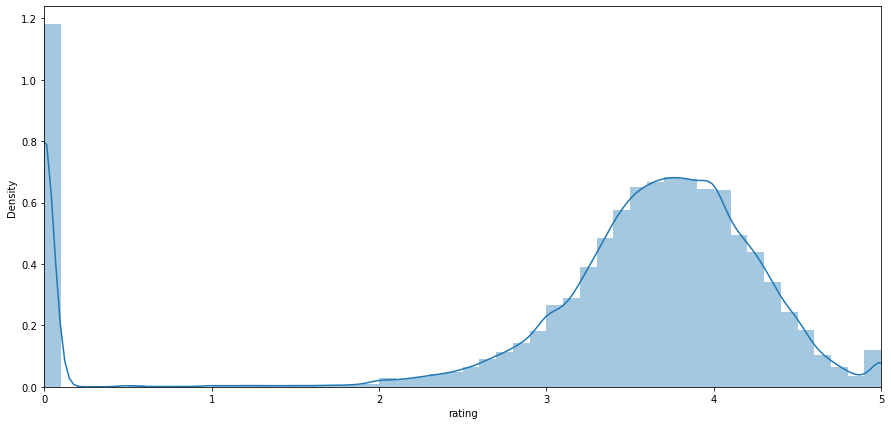

In [166]:
#Check ratings
plt.figure(figsize=(15,7))
sns.distplot(list(predicted_rating_i.stack()))
plt.xlim(0,5)
plt.xlabel('rating')
plt.savefig('ii_pred.png')
plt.show()

In [155]:
#Preview of updated predicted ratings
predicted_rating_i

movieId,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,4.399258,4.397623,4.383900,4.397976,4.383968,4.391377,4.356745,4.348761,4.181925,4.372380,...,4.310154,4.565125,4.400940,0.0,4.519594,4.350752,4.486024,4.431052,4.506343,4.431052
2,3.816648,3.782189,3.634592,3.689522,3.794300,3.798158,3.736820,3.844211,3.747030,3.801246,...,4.008239,3.655164,4.098969,0.0,3.997348,3.814542,3.582178,3.277170,3.951292,3.277170
3,1.672108,1.621323,1.784543,0.736915,1.484373,1.804931,1.251029,1.627394,1.895025,1.846131,...,2.000000,1.729122,1.251330,0.0,0.500000,1.874792,2.200741,1.837407,2.365532,1.837407
4,3.452587,3.439087,3.445041,3.422919,3.521686,3.458727,3.463270,3.124187,3.341759,3.366175,...,3.518677,3.403778,3.608378,0.0,3.645715,3.613270,3.206638,3.673874,3.499820,3.673874
5,3.665861,3.574810,3.531982,3.568655,3.623004,3.605466,3.602839,3.699152,3.743209,3.510960,...,3.502052,3.232720,3.470367,0.0,3.922695,3.582456,3.575006,3.262633,3.540373,3.262633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.666876,3.601856,3.537158,3.741633,3.606401,3.733438,3.664717,3.483160,3.536170,3.615415,...,3.318045,3.567080,3.500261,0.0,3.707371,3.520490,3.517293,3.306077,3.717088,3.306077
607,3.704956,3.695681,3.716576,3.715055,3.697724,3.728806,3.685615,3.740476,3.438607,3.701737,...,3.569992,3.472700,3.589709,0.0,3.740642,3.557665,3.709958,3.804444,3.727937,3.804444
608,3.235733,3.202309,3.092767,2.738047,3.118297,3.317684,3.045353,2.959440,2.768974,3.228674,...,3.483385,3.288968,3.319997,0.0,3.359832,2.978349,3.138755,3.048159,3.399479,3.048159


### 5.4 Model-based collaborative filtering

* SVD and KNN recommenders from the Surprise package were used to demonstrate model-based collaborative filtering 
* Model-based collaborative filtering involved predicting test set movie ratings, which were ranked to provide recommendations
* KNN recommenders were designed to in a similar fashion to memory-based collaborative filtering - both user-user and item-item based.

In [157]:
#Surprise models - SVD, KNNWithMeans, KNNBasic

#SVD, matrix factorisation
svd = SVD()

#KNN user-user collaborative filtering
knn_uu = KNNWithMeans(sim_options = {'name': 'pearson'}, user_based = True)

#KNN item-item collaborative filtering
knn_ii = KNNBasic(sim_options = {'name': 'cosine'}, user_based = False)

surprise_models = [svd, knn_uu, knn_ii]

In [158]:
#Recommendations from surprise results

#Store recommendations
surprise_recs = []

for model in surprise_models: 
    model_recs = surprise_algo(model, trainset_surprise, testset_surprise, userIds)
    surprise_recs.append(model_recs) 

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [159]:
surprise_recs = pd.DataFrame(surprise_recs).transpose()
surprise_recs.index = userIds
surprise_recs.columns = ['SVD_recs', 'KNN_user_user_recs', 'KNN_item_item_recs']

In [160]:
#user_items = user_items[user_items.columns[:6]]

In [161]:
user_items = pd.merge(user_items, surprise_recs, left_index=True, right_index=True)
user_items

,movieId,rating,actuals,content_based_rec,user_user_rec,item_item_rec,SVD_recs,KNN_user_user_recs,KNN_item_item_recs
userId,,,,,,,,,
1,"[1, 3, 6, 47, 50, 70, 101, 151, 157, 163, 223,...","[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, ...","[2991, 3053, 2459, 1198, 1025, 2502, 608, 5060...","[180497, 26171, 178615, 74647, 128852, 4298, 5...","[318, 296, 858, 1198, 593, 1210, 356, 1221, 42...","[160848, 169034, 167732, 2493, 4957, 1140, 103...","[1198, 1258, 1210, 1208, 457, 608, 1206, 3448,...","[1198, 1258, 2502, 1222, 593, 1208, 1954, 457,...","[1210, 296, 356, 1208, 3578, 110, 1198, 1206, ..."
2,"[318, 333, 131724, 1704, 68157, 71535, 6874, 1...","[3.0, 4.0, 5.0, 4.5, 4.5, 3.0, 4.0, 5.0, 3.5, ...","[89774, 58559, 80489, 74458, 3578]","[180497, 4105, 81784, 71530, 4366, 20, 5771, 4...","[344, 367, 72998, 434, 410, 44, 788, 231, 208,...","[4402, 101973, 133780, 152270, 138396, 112454,...","[58559, 115713, 3578, 74458, 80489, 99114, 89774]","[99114, 115713, 58559, 3578, 80489, 74458, 89774]","[58559, 99114, 74458, 115713, 80489, 3578, 89774]"
3,"[31, 647, 688, 720, 849, 1124, 1263, 1272, 130...","[0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, 0.5, ...","[5919, 5746, 1587, 26409]","[178615, 172233, 44511, 171811, 5325, 140816, ...","[380, 173, 47, 880, 788, 3535, 420, 3527, 2985...","[6949, 93610, 1105, 6752, 2582, 1167, 879, 889...","[527, 3949, 914, 1275, 3210, 1587, 5919, 5746,...","[5919, 5746, 1275, 914, 1587, 527, 3210, 3949,...","[527, 914, 3949, 1275, 1093, 3210, 5919, 5746,..."
4,"[21, 32, 47, 52, 58, 106, 125, 126, 162, 171, ...","[3.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, 5.0, ...","[920, 2599, 1197, 1080, 3044, 1947, 910, 265, ...","[180497, 4105, 4298, 5670, 73042, 6319, 26171,...","[318, 858, 1097, 750, 1247, 1270, 260, 111, 27...","[190209, 190213, 96430, 190221, 190219, 189111...","[898, 1197, 1080, 260, 930, 899, 904, 910, 414...","[4273, 4144, 1060, 4881, 904, 1203, 930, 2395,...","[4273, 4144, 2959, 904, 898, 1197, 2324, 1203,..."
5,"[34, 36, 58, 153, 232, 247, 261, 266, 290, 296...","[4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 4.0, 1.0, 5.0, ...","[21, 367, 474, 1, 50, 110]","[1635, 4105, 122932, 180497, 27370, 7301, 6319...","[50, 593, 356, 150, 1, 32, 161, 110, 4226, 858...","[185031, 173925, 83369, 176601, 170827, 4523, ...","[50, 150, 1, 110, 265, 253, 474, 21, 357, 39, ...","[50, 1, 150, 265, 110, 474, 253, 357, 21, 39, ...","[50, 150, 110, 1, 265, 253, 474, 357, 21, 367,..."
...,...,...,...,...,...,...,...,...,...
606,"[1, 11, 15, 18, 19, 29, 32, 36, 47, 58, 73, 80...","[2.5, 2.5, 3.5, 4.0, 2.0, 4.5, 4.0, 3.5, 3.0, ...","[1089, 2997, 910, 2360, 2959, 1682, 1193, 3855...","[4105, 4298, 180497, 6994, 3445, 5009, 1642, 8...","[2959, 50, 608, 1221, 1197, 4973, 1213, 1089, ...","[44889, 169034, 160848, 44633, 26366, 6408, 26...","[2959, 4973, 50, 1234, 908, 1221, 2194, 3681, ...","[7327, 7121, 1217, 6791, 4745, 6100, 50, 2206,...","[3855, 7486, 7121, 1041, 2959, 1217, 8724, 356..."
607,"[1, 11, 25, 112, 153, 165, 188, 204, 208, 241,...","[4.0, 3.0, 3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 3.0, ...","[1370, 2762, 110, 2571, 150, 3347, 1974, 1407,...","[180497, 4298, 4105, 178615, 71530, 26171, 422...","[318, 110, 356, 364, 32, 47, 595, 150, 1221, 5...","[120130, 114265, 124851, 44633, 167732, 113829...","[318, 2028, 1394, 1304, 2571, 1240, 36, 1282, ...","[318, 110, 1394, 3347, 1997, 1282, 2747, 150, ...","[318, 2571, 150, 2028, 110, 1210, 2762, 1394, ..."
608,"[2, 3, 16, 21, 24, 31, 32, 34, 39, 44, 47, 48,...","[2.0, 2.0, 4.5, 3.5, 2.0, 3.0, 3.5, 3.5, 3.0, ...","[7373, 296, 53996, 3949, 2502, 54503, 6373, 65...","[180497, 4298, 26171, 71530, 5670, 178615, 141...","[296, 593, 1198, 1197, 608, 7361, 4993, 7153, ...","[124851, 113829, 114265, 189111, 190209, 19021...","[296, 608, 2502, 593, 2762, 111, 2529, 541, 83...","[296, 6857, 2550, 778, 2502, 608, 7361, 7153, ...","[296, 593, 7153, 7361, 1222, 1193, 4993, 2502,..."


## 7. Evaluation

In [162]:
#Columns in 'user_items' with user recommendations
rec_cols = user_items.columns[3:]
rec_cols

Index(['content_based_rec', 'user_user_rec', 'item_item_rec', 'SVD_recs',
       'KNN_user_user_recs', 'KNN_item_item_recs'],
      dtype='object')

In [163]:
#Results for Mean Average Precision @ K (MAPk), where K = 10

#Print and store MAPk results
mapk = [] 

for rec in rec_cols: 
    mapk_ = metrics.mapk(user_items['actuals'], user_items[rec], k=10)
    print(rec, ': ', mapk_)
    mapk.append(mapk_)

content_based_rec :  0.015292674993494666
user_user_rec :  0.15085125398064508
item_item_rec :  0.014754098360655738
SVD_recs :  0.6797903253286742
KNN_user_user_recs :  0.6779644718391303
KNN_item_item_recs :  0.6884300059580601


In [164]:
#Results dataframe
mapk = pd.DataFrame([rec_cols, mapk]).transpose()
mapk.columns = ['model', 'MAP@k, k=10']
mapk = mapk.sort_values('MAP@k, k=10')

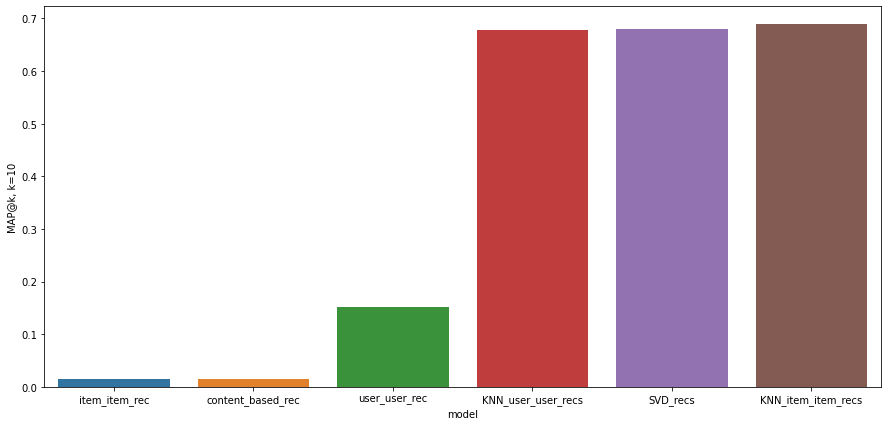

In [165]:
#Plot results  
plt.figure(figsize=(15,7))
sns.barplot(data = mapk, x='model', y= 'MAP@k, k=10')
plt.savefig('mapk.png')
plt.show()

**Findings**

*Content-based*
* Using genres only to develop content-based recommendations do not indicate a relatively high MAP@k. There was a bias to recommend movies associated with more genres listed. The recommeder could be improved by adding more attributes, such as movie cast names, directors and movie tags. 

*Recommenders built from scratch*
* The user-based recommender performed better than the item-based recommender. 
* This could be due to various reasons: 
    * There were less users than movies in the data 
    * User similarities were more distinguishable than item similarities; user similarities ranged between -1 and 1, while item similarities ranged between 0 and 1
    * The item-based recommender predicted a significant amount of zero ratings, overlooking a larger variety of movies to recommend

*Model-based recommenders*
* Performed better than recommenders built from scratch. This is likely due to the algorithms selecting only a number of user/item similarities rather than applying all users/items during computation. Given the sparsity in the user-item matrix, it is likely most users/items show insignificant levels of similarities. 
* The MAP@K, where K = 10, shows **item-item collaborative filtering using KNNBasic** performed the best on the test set, and marginally better than the other algorithms. 